# Rawan Reda Abbas        20227011
# Aliaa Osama Hussein     20227017
# Radwa NasrUldin Ewais 20227010
# Amr Khaled Salah           20227036  
# Khaled Omar Hassan     20227009

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN, KMeans
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score
from sklearn.utils import check_random_state
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score


from warnings import filterwarnings 
filterwarnings('ignore')

C:\Users\rawan\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Reading the data

### what we want to know is how many types of penguins are there??

In [2]:
df = pd.read_csv("penguins.csv")
df

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,39.1,18.7,181.0,3750.0,MALE
1,39.5,17.4,186.0,3800.0,FEMALE
2,40.3,18.0,195.0,3250.0,FEMALE
3,NaN,NaN,NaN,NaN,NaN
4,36.7,19.3,193.0,3450.0,FEMALE
...,...,...,...,...,...
339,NaN,NaN,NaN,NaN,NaN
340,46.8,14.3,215.0,4850.0,FEMALE
341,50.4,15.7,222.0,5750.0,MALE
342,45.2,14.8,212.0,5200.0,FEMALE


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   culmen_length_mm   342 non-null    float64
 1   culmen_depth_mm    342 non-null    float64
 2   flipper_length_mm  342 non-null    float64
 3   body_mass_g        342 non-null    float64
 4   sex                335 non-null    object 
dtypes: float64(4), object(1)
memory usage: 13.6+ KB


The number of features are 5.

In [4]:
df.isnull().sum()

culmen_length_mm     2
culmen_depth_mm      2
flipper_length_mm    2
body_mass_g          2
sex                  9
dtype: int64

In [5]:
df.dropna(inplace=True)

In [6]:
df.isnull().sum()

culmen_length_mm     0
culmen_depth_mm      0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

In [7]:
le = LabelEncoder()
df['sex'] = le.fit_transform(df['sex'])

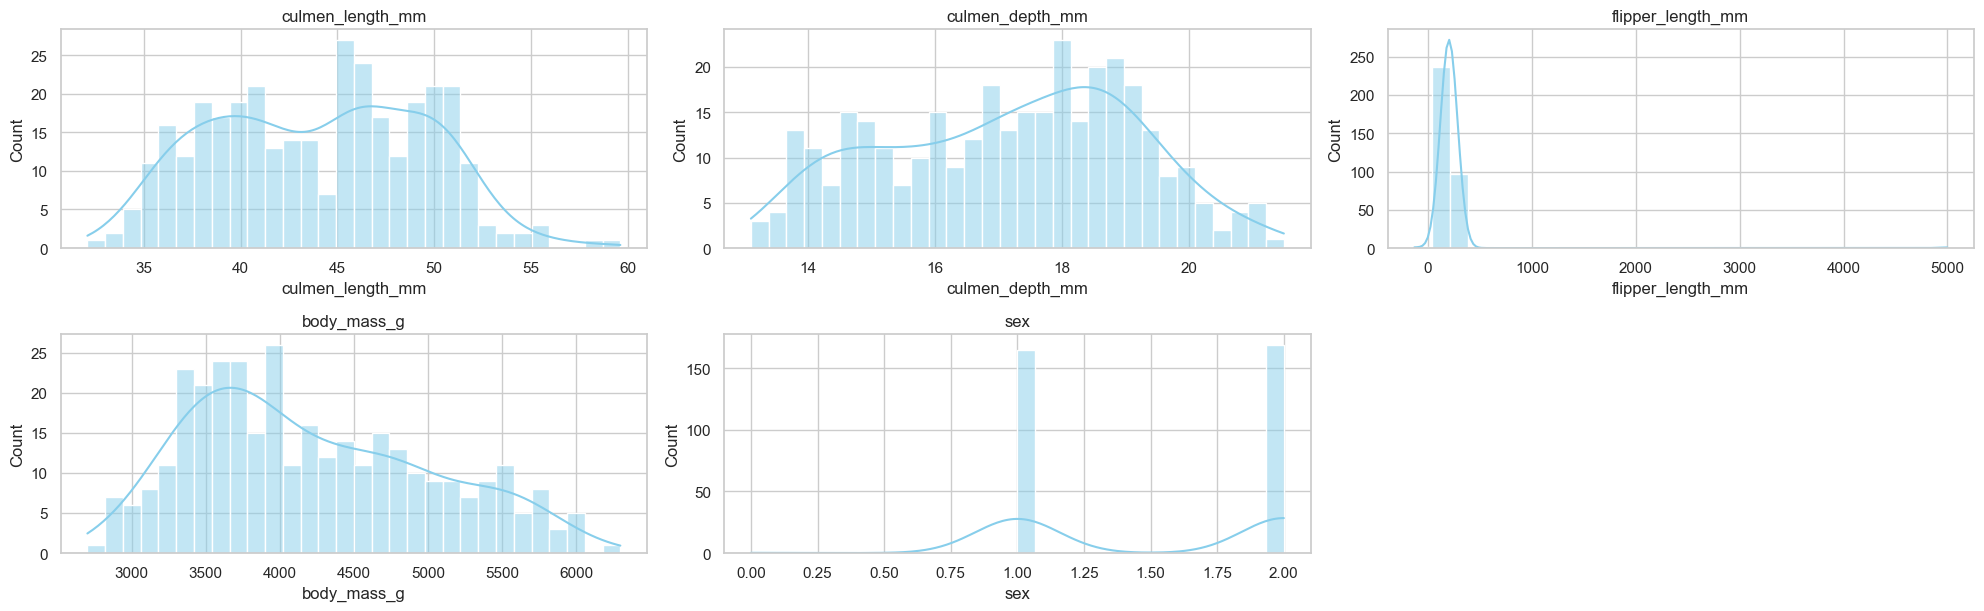

In [8]:
# Set the plotting style
sns.set(style="whitegrid")

# Select numeric columns to plot
columns_to_plot = [
    'culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex'
]

# Set up the figure size and layout
plt.figure(figsize=(20, 18))
for i, col in enumerate(columns_to_plot, 1):
    plt.subplot(6, 3, i)
    sns.histplot(df[col].dropna(), kde=True, bins=30, color='skyblue')
    plt.title(col)
    plt.tight_layout()

plt.show()

# Hopkins Function

In [19]:
def hopkins(X, n_samples=0.1, random_state=1):
    if isinstance(n_samples, float):
        n_samples = int(n_samples * X.shape[0])
    else:
        n_samples = min(n_samples, X.shape[0])
    d = X.shape[1]
    rng = check_random_state(random_state)
    sample_indices = rng.choice(np.arange(X.shape[0]), n_samples, replace=False)
    X_sample = X[sample_indices]
    X_min, X_max = np.min(X, axis=0), np.max(X, axis=0)
    random_points = rng.uniform(X_min, X_max, (n_samples, d))
    nbrs = NearestNeighbors(n_neighbors=2).fit(X)
    u_distances, _ = nbrs.kneighbors(random_points, n_neighbors=1)
    u_sum = u_distances.sum()
    w_distances, indices = nbrs.kneighbors(X_sample, n_neighbors=2)
    w_sum = w_distances[:, 1].sum()  
    H = u_sum / (u_sum + w_sum)
    return H

In [20]:
hopkins(df.values)

0.9951558745904193

### As showen the accuracy is more than 0.5 which meens that it is sutable for clustering 

#### Interpretation of Hopkins Statistic:

~1.0 → Data is highly clusterable (very different from random).

~0.5 → Data is uniformly random (no meaningful clusters).

< 0.5 → Unusual; may indicate issues or that the data is more regular than random (not typical in natural datasets).

# let as see the Empirical, Elbow and Cross Validation method to know the sutable number of clusters

### 1. Empirical Method 

In [12]:
# Empirical rule: k ≈ sqrt(n/2)
n = len(df)
empirical_k = int(np.sqrt(n / 2))
print("Empirical K estimate:", empirical_k)

Empirical K estimate: 12


### 2. Elbow Method

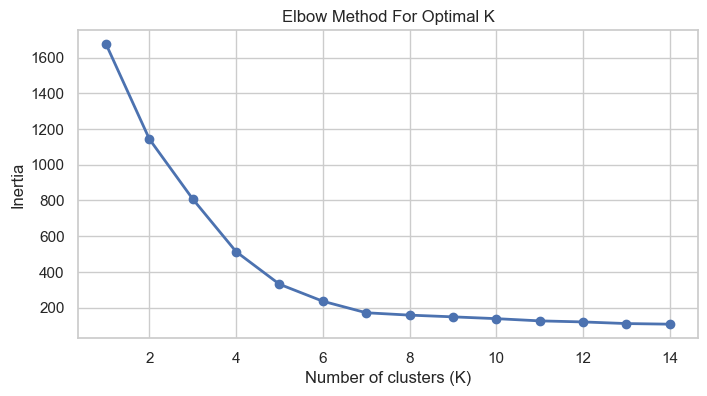

In [13]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df.dropna())

inertia = []
K_range = range(1, 15)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

    
# Plot the Elbow curve
plt.figure(figsize=(8, 4))
plt.plot(K_range, inertia, 'bo-', linewidth=2)
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal K')
plt.grid(True)
plt.show()

in the Elbow method the best k is 4 

### 3. Cross-Validation with Silhouette Score

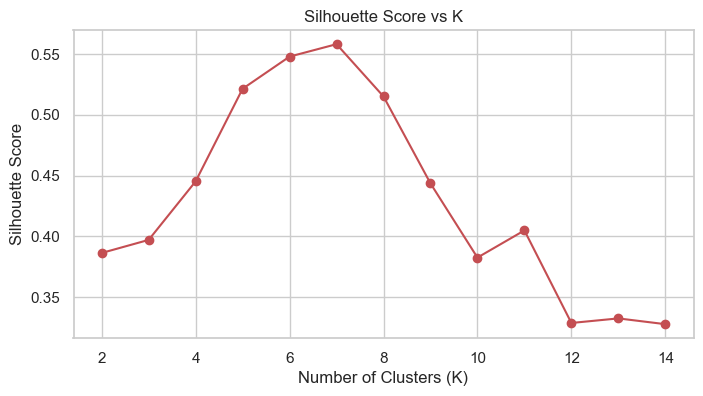

In [14]:
silhouette_scores = []

for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(df_scaled)
    score = silhouette_score(df_scaled, labels)
    silhouette_scores.append(score)

# Plot silhouette scores
plt.figure(figsize=(8, 4))
plt.plot(range(2, 15), silhouette_scores, 'ro-')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs K")
plt.grid(True)
plt.show()

In Silhouette score the best number of k is 7

### therefor we will run the models at k=[4, 7, 12]

# 1. K-Medoids Clustering

K-medoids clustering is a variant of K-means that is more robust to noises and outliers. Instead of using the mean point as the center of a cluster, K-medoids uses an actual point in the cluster to represent it. Medoid is the most centrally located object of the cluster, with minimum sum of distances to other points.

In [15]:


# Clean and scale your data
df_clean = df.dropna()
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_clean)

# List of K values to test
k_values = [4,7,12]

best_k = None
best_score = -1
best_labels = None

for k in k_values:
    kmedoids = KMedoids(n_clusters=k, random_state=42)
    labels = kmedoids.fit_predict(df_scaled)
    
    score = silhouette_score(df_scaled, labels)
    print(f"K={k} -> Silhouette Score: {score:.4f}")
    
    if score > best_score:
        best_k = k
        best_score = score
        best_labels = labels

print(f"\n✅ Best K: {best_k} with Silhouette Score: {best_score:.4f}")


K=4 -> Silhouette Score: 0.3902
K=7 -> Silhouette Score: 0.4223
K=12 -> Silhouette Score: 0.3740

✅ Best K: 7 with Silhouette Score: 0.4223


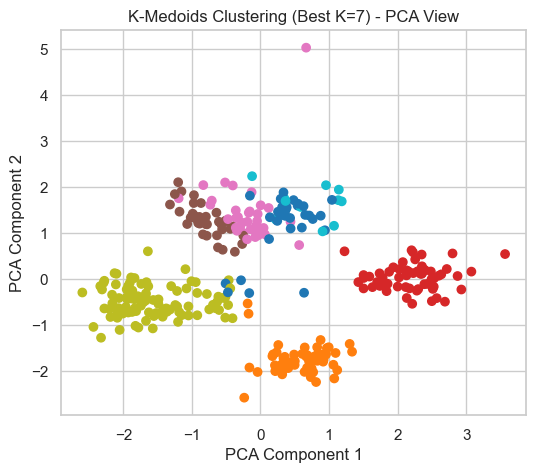

In [16]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce to 2D for visualization
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

# Plot the best clustering
plt.figure(figsize=(6, 5))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=best_labels, cmap='tab10')
plt.title(f"K-Medoids Clustering (Best K={best_k}) - PCA View")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()

# 2. DBSCAN Clustering

It is a density-based clustering non-parametric algorithm: given a set of points in some space, it groups together points that are closely packed (points with many nearby neighbors), and marks as outliers points that lie alone in low-density regions (those whose nearest neighbors are too far away).

### Core Parameters of DBSCAN:
eps — the radius within which points are considered neighbors.

min_samples — the minimum number of neighbors required to form a dense region.

In [17]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import numpy as np

# Clean and scale the data
df_clean = df.dropna()
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_clean)

# Try multiple eps values
eps_values = [0.5,0.8, 1.0, 1.5]
best_eps = None
best_score = -1
best_labels = None

for eps in eps_values:
    db = DBSCAN(eps=eps, min_samples=5)
    labels = db.fit_predict(df_scaled)

    # Check if the clustering found more than 1 cluster (excluding noise)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    if n_clusters <= 1:
        print(f"eps={eps} -> only {n_clusters} cluster(s), skipping silhouette score.")
        continue

    score = silhouette_score(df_scaled, labels)
    print(f"eps={eps} -> Silhouette Score: {score:.4f} | Clusters: {n_clusters}")
    
    if score > best_score:
        best_eps = eps
        best_score = score
        best_labels = labels

if best_labels is not None:
    print(f"\n✅ Best eps: {best_eps} with Silhouette Score: {best_score:.4f}")
else:
    print("\n⚠️ No valid clustering found with more than 1 cluster.")


eps=0.5 -> Silhouette Score: 0.4487 | Clusters: 7
eps=0.8 -> Silhouette Score: 0.5115 | Clusters: 4
eps=1.0 -> Silhouette Score: 0.3798 | Clusters: 3
eps=1.5 -> Silhouette Score: 0.3590 | Clusters: 2

✅ Best eps: 0.8 with Silhouette Score: 0.5115


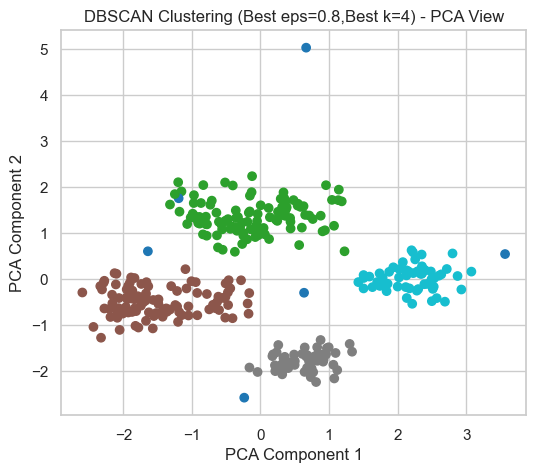

In [18]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce to 2D with PCA for visualization
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

# Plot best DBSCAN result
plt.figure(figsize=(6, 5))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=best_labels, cmap='tab10')
plt.title(f"DBSCAN Clustering (Best eps={best_eps},Best k=4) - PCA View")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()


### What we learned is that we have 4 types of penguins.
#### Note the dark blue points are outliers

# Discuss each algorithm quality results for your dataset in brief, which one suited the dataset better and why do you think is that?

###  DBSCAN Clustering

Let’s break down the key points:

✅ Density-based: It finds clusters based on areas where data points are densely packed.

✅ Non-parametric: You don’t need to specify the number of clusters beforehand (unlike K-Means or K-Medoids).

✅ Groups points with many neighbors: Points in high-density regions are clustered together.

✅ Identifies outliers: Points in low-density regions (few neighbors) are labeled as noise (-1).

# Why we didn't choose K-Medoids?

### As shown above the K-Medoids the points are overlaping and we don't think that is right.